In [1]:
import glob
import json
import os
import shutil
import operator
import sys
import argparse
import pandas as pd

MINOVERLAP = 0.50 # default value (defined in the PASCAL VOC2012 challenge)

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('-na', '--no-animation', help="no animation is shown.", action="store_true")
parser.add_argument('-np', '--no-plot', help="no plot is shown.", action="store_true")
parser.add_argument('-q', '--quiet', help="minimalistic console output.", action="store_true")
# argparse receiving list of classes to be ignored
parser.add_argument('-i', '--ignore', nargs='+', type=str, help="ignore a list of classes.")
# argparse receiving list of classes with specific IoU
parser.add_argument('--set-class-iou', nargs='+', type=str, help="set IoU for a specific class.")
args = parser.parse_args(args=[])

In [3]:
# if there are no classes to ignore then replace None by empty list
if args.ignore is None:
  args.ignore = []

specific_iou_flagged = False
if args.set_class_iou is not None:
  specific_iou_flagged = True

# if there are no images then no animation can be shown
img_path = 'images'
if os.path.exists(img_path): 
  for dirpath, dirnames, files in os.walk(img_path):
    if not files:
      # no image files found
      args.no_animation = True
else:
  args.no_animation = True

In [4]:
# try to import OpenCV if the user didn't choose the option --no-animation
show_animation = False
if not args.no_animation:
  try:
    import cv2
    show_animation = True
  except ImportError:
    print("\"opencv-python\" not found, please install to visualize the results.")
    args.no_animation = True

# try to import Matplotlib if the user didn't choose the option --no-plot
draw_plot = False
if not args.no_plot:
  try:
    import matplotlib.pyplot as plt
    draw_plot = True
  except ImportError:
    print("\"matplotlib\" not found, please install it to get the resulting plots.")
    args.no_plot = True


In [5]:
"""
 throw error and exit
"""
def error(msg):
  print(msg)
  sys.exit(0)

"""
 check if the number is a float between 0.0 and 1.0
"""
def is_float_between_0_and_1(value):
  try:
    val = float(value)
    if val > 0.0 and val < 1.0:
      return True
    else:
      return False
  except ValueError:
    return False


In [6]:
"""
 Calculate the AP given the recall and precision array
  1st) We compute a version of the measured precision/recall curve with
       precision monotonically decreasing
  2nd) We compute the AP as the area under this curve by numerical integration.
"""
def voc_ap(rec, prec):
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    # matlab indexes start in 1 but python in 0, so I have to do:
    #   range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #   range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
    This part creates a list of indexes where the recall changes
    matlab:  i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
    The Average Precision (AP) is the area under the curve
    (numerical integration)
    matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre

In [7]:
"""
 Convert the lines of a file to a list
"""
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
        # remove whitespace characters like `\n` at the end of each line
        content = [x.strip() for x in content]
    return content


In [8]:
"""
 Draws text in image
"""
def draw_text_in_image(img, text, pos, color, line_width):
    font = cv2.FONT_HERSHEY_PLAIN
    fontScale = 1
    lineType = 1
    bottomLeftCornerOfText = pos
    cv2.putText(img, text,
                bottomLeftCornerOfText,
                font,
                fontScale,
                color,
                lineType)
    text_width, _ = cv2.getTextSize(text, font, fontScale, lineType)[0]
    return img, (line_width + text_width)


In [9]:
"""
 Plot - adjust axes
"""
def adjust_axes(r, t, fig, axes):
    # get text width for re-scaling
    bb = t.get_window_extent(renderer=r)
    text_width_inches = bb.width / fig.dpi
    # get axis width in inches
    current_fig_width = fig.get_figwidth()
    new_fig_width = current_fig_width + text_width_inches
    propotion = new_fig_width / current_fig_width
    # get axis limit
    x_lim = axes.get_xlim()
    axes.set_xlim([x_lim[0], x_lim[1]*propotion])

In [10]:

"""
 Draw plot using Matplotlib
"""
def draw_plot_func(dictionary, n_classes, window_title, plot_title, x_label, output_path, to_show, plot_color, true_p_bar):
  # sort the dictionary by decreasing value, into a list of tuples
  sorted_dic_by_value = sorted(dictionary.items(), key=operator.itemgetter(1))
  # unpacking the list of tuples into two lists
  sorted_keys, sorted_values = zip(*sorted_dic_by_value)
  # 
  if true_p_bar != "":
    """
     Special case to draw in (green=true predictions) & (red=false predictions)
    """
    fp_sorted = []
    tp_sorted = []
    for key in sorted_keys:
      fp_sorted.append(dictionary[key] - true_p_bar[key])
      tp_sorted.append(true_p_bar[key])
    plt.barh(range(n_classes), fp_sorted, align='center', color='crimson', label='False Predictions')
    plt.barh(range(n_classes), tp_sorted, align='center', color='forestgreen', label='True Predictions', left=fp_sorted)
    # add legend
    plt.legend(loc='lower right')
    """
     Write number on side of bar
    """
    fig = plt.gcf() # gcf - get current figure
    axes = plt.gca()
    r = fig.canvas.get_renderer()
    for i, val in enumerate(sorted_values):
      fp_val = fp_sorted[i]
      tp_val = tp_sorted[i]
      fp_str_val = " " + str(fp_val)
      tp_str_val = fp_str_val + " " + str(tp_val)
      # trick to paint multicolor with offset:
      #   first paint everything and then repaint the first number
      t = plt.text(val, i, tp_str_val, color='forestgreen', va='center', fontweight='bold')
      plt.text(val, i, fp_str_val, color='crimson', va='center', fontweight='bold')
      if i == (len(sorted_values)-1): # largest bar
        adjust_axes(r, t, fig, axes)
  else:
    plt.barh(range(n_classes), sorted_values, color=plot_color)
    """
     Write number on side of bar
    """
    fig = plt.gcf() # gcf - get current figure
    axes = plt.gca()
    r = fig.canvas.get_renderer()
    for i, val in enumerate(sorted_values):
      str_val = " " + str(val) # add a space before
      if val < 1.0:
        str_val = " {0:.2f}".format(val)
      t = plt.text(val, i, str_val, color=plot_color, va='center', fontweight='bold')
      # re-set axes to show number inside the figure
      if i == (len(sorted_values)-1): # largest bar
        adjust_axes(r, t, fig, axes)
  # set window title
  fig.canvas.set_window_title(window_title)
  # write classes in y axis
  tick_font_size = 12
  plt.yticks(range(n_classes), sorted_keys, fontsize=tick_font_size)
  """
   Re-scale height accordingly
  """
  init_height = fig.get_figheight()
  # comput the matrix height in points and inches
  dpi = fig.dpi
  height_pt = n_classes * (tick_font_size * 1.4) # 1.4 (some spacing)
  height_in = height_pt / dpi
  # compute the required figure height 
  top_margin = 0.15    # in percentage of the figure height
  bottom_margin = 0.05 # in percentage of the figure height
  figure_height = height_in / (1 - top_margin - bottom_margin)
  # set new height
  if figure_height > init_height:
    fig.set_figheight(figure_height)

  # set plot title
  plt.title(plot_title, fontsize=14)
  # set axis titles
  # plt.xlabel('classes')
  plt.xlabel(x_label, fontsize='large')
  # adjust size of window
  fig.tight_layout()
  # save the plot
  fig.savefig(output_path)
  # show image
  if to_show:
    plt.show()
  # close the plot
  plt.close()


In [11]:
def tempFiles(directory = ""):
    """
     Create a "tmp_files/" and "results/" directory
    """
    tmp_files_path = "tmp_files/"
    if not os.path.exists(tmp_files_path): # if it doesn't exist already
      os.makedirs(tmp_files_path)
    results_files_path = "results/"+directory
    if os.path.exists(results_files_path): # if it exist already
      # reset the results directory
      shutil.rmtree(results_files_path)

    os.makedirs(results_files_path)
    if draw_plot:
      os.makedirs(results_files_path + "/classes")
    if show_animation:
      os.makedirs(results_files_path + "/images")
      os.makedirs(results_files_path + "/images/single_predictions")
    return(tmp_files_path,results_files_path)



def Load_GroundTruthFiles():
    """
     Ground-Truth
       Load each of the ground-truth files into a temporary ".json" file.
       Create a list of all the class names present in the ground-truth (gt_classes).
    """
    # get a list with the ground-truth files
    ground_truth_files_list = glob.glob('ground-truth/*.txt')
    if len(ground_truth_files_list) == 0:
      error("Error: No ground-truth files found!")
    ground_truth_files_list.sort()
    # dictionary with counter per class
    gt_counter_per_class = {}

    for txt_file in ground_truth_files_list:
      #print(txt_file)
      file_id = txt_file.split(".txt",1)[0]
      file_id = os.path.basename(os.path.normpath(file_id))
      # check if there is a correspondent predicted objects file
        
      ''' 
      if not os.path.exists(predicted +"/" +file_id + ".txt"):
        error_msg = "Error. File not found: predicted/" +  file_id + ".txt\n"
        error_msg += "(You can avoid this error message by running extra/intersect-gt-and-pred.py)"
        error(error_msg)
        
      '''
      lines_list = file_lines_to_list(txt_file)
      # create ground-truth dictionary
      bounding_boxes = []
      is_difficult = False
      for line in lines_list:
        try:
          if "difficult" in line:
              class_name, left, top, right, bottom, _difficult = line.split()
              is_difficult = True
          else:
              class_name, left, top, right, bottom = line.split()
        except ValueError:
          error_msg = "Error: File " + txt_file + " in the wrong format.\n"
          error_msg += " Expected: <class_name> <left> <top> <right> <bottom> ['difficult']\n"
          error_msg += " Received: " + line
          error_msg += "\n\nIf you have a <class_name> with spaces between words you should remove them\n"
          error_msg += "by running the script \"remove_space.py\" or \"rename_class.py\" in the \"extra/\" folder."
          error(error_msg)
        # check if class is in the ignore list, if yes skip
        if class_name in args.ignore:
          continue
        bbox = left + " " + top + " " + right + " " +bottom
        if is_difficult:
            bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False, "difficult":True})
            is_difficult = False
        else:
            bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False})
            # count that object
            if class_name in gt_counter_per_class:
              gt_counter_per_class[class_name] += 1
            else:
              # if class didn't exist yet
              gt_counter_per_class[class_name] = 1
      # dump bounding_boxes into a ".json" file
      with open(tmp_files_path + "/" + file_id + "_ground_truth.json", 'w') as outfile:
            json.dump(bounding_boxes, outfile)
    return(gt_counter_per_class, ground_truth_files_list)




In [12]:
"""
 Check format of the flag --set-class-iou (if used)
  e.g. check if class exists
"""
if specific_iou_flagged:
  n_args = len(args.set_class_iou)
  error_msg = \
    '\n --set-class-iou [class_1] [IoU_1] [class_2] [IoU_2] [...]'
  if n_args % 2 != 0:
    error('Error, missing arguments. Flag usage:' + error_msg)
  # [class_1] [IoU_1] [class_2] [IoU_2]
  # specific_iou_classes = ['class_1', 'class_2']
  specific_iou_classes = args.set_class_iou[::2] # even
  # iou_list = ['IoU_1', 'IoU_2']
  iou_list = args.set_class_iou[1::2] # odd
  if len(specific_iou_classes) != len(iou_list):
    error('Error, missing arguments. Flag usage:' + error_msg)
  for tmp_class in specific_iou_classes:
    if tmp_class not in gt_classes:
          error('Error, unknown class \"' + tmp_class + '\". Flag usage:' + error_msg)
  for num in iou_list:
    if not is_float_between_0_and_1(num):
      error('Error, IoU must be between 0.0 and 1.0. Flag usage:' + error_msg)

def Load_PredictionFiles(predicted, gt_classes, groundtruth):
    """
     Predicted
       Load each of the predicted files into a temporary ".json" file.
    """
    # get a list with the predicted files
    predicted_files_list = glob.glob(predicted+'/*.txt')
    predicted_files_list.sort()

    for class_index, class_name in enumerate(gt_classes):
      bounding_boxes = []
      for txt_file in predicted_files_list:
        #print(txt_file)
        # the first time it checks if all the corresponding ground-truth files exist
        file_id = txt_file.split(".txt",1)[0]
        file_id = os.path.basename(os.path.normpath(file_id))
        if class_index == 0:
          if not os.path.exists(groundtruth+'/' + file_id + ".txt"):
            error_msg = "Error. File not found: ground-truth/" +  file_id + ".txt\n"
            error_msg += "(You can avoid this error message by running extra/intersect-gt-and-pred.py)"
            error(error_msg)
        lines = file_lines_to_list(txt_file)
        for line in lines:
          try:
            tmp_class_name, confidence, left, top, right, bottom = line.split()
          except ValueError:
            error_msg = "Error: File " + txt_file + " in the wrong format.\n"
            error_msg += " Expected: <class_name> <confidence> <left> <top> <right> <bottom>\n"
            error_msg += " Received: " + line
            error(error_msg)
          if tmp_class_name == class_name:
            #print("match")
            bbox = left + " " + top + " " + right + " " +bottom
            bounding_boxes.append({"confidence":confidence, "file_id":file_id, "bbox":bbox})
            #print(bounding_boxes)
      # sort predictions by decreasing confidence
      bounding_boxes.sort(key=lambda x:float(x['confidence']), reverse=True)
      with open(tmp_files_path + "/" + class_name + "_predictions.json", 'w') as outfile:
        json.dump(bounding_boxes, outfile)
    return(predicted_files_list)
        


In [13]:
def aP_and_mAP_Calculation(gt_classes, gt_counter_per_class, n_classes,  results_files_path ):

    """
     Calculate the AP for each class
    """

    sum_AP = 0.0
    ap_dictionary = {}

    # open file to store the results
    with open(results_files_path + "/results.txt", 'w') as results_file:
      results_file.write("# AP and precision/recall per class\n")
      count_true_positives = {}
      for class_index, class_name in enumerate(gt_classes):
        count_true_positives[class_name] = 0
        """
         Load predictions of that class
        """
        predictions_file = tmp_files_path + "/" + class_name + "_predictions.json"
        predictions_data = json.load(open(predictions_file))

        """
         Assign predictions to ground truth objects
        """
        nd = len(predictions_data)
        tp = [0] * nd # creates an array of zeros of size nd
        fp = [0] * nd
        for idx, prediction in enumerate(predictions_data):
          file_id = prediction["file_id"]
          if show_animation:
            # find ground truth image
            ground_truth_img = glob.glob1(img_path, file_id + ".*")
            #tifCounter = len(glob.glob1(myPath,"*.tif"))
            if len(ground_truth_img) == 0:
              error("Error. Image not found with id: " + file_id)
            elif len(ground_truth_img) > 1:
              error("Error. Multiple image with id: " + file_id)
            else: # found image
              #print(img_path + "/" + ground_truth_img[0])
              # Load image
              img = cv2.imread(img_path + "/" + ground_truth_img[0])
              # load image with draws of multiple detections
              img_cumulative_path = results_files_path + "/images/" + ground_truth_img[0]
              if os.path.isfile(img_cumulative_path):
                img_cumulative = cv2.imread(img_cumulative_path)
              else:
                img_cumulative = img.copy()
              # Add bottom border to image
              bottom_border = 60
              BLACK = [0, 0, 0]
              img = cv2.copyMakeBorder(img, 0, bottom_border, 0, 0, cv2.BORDER_CONSTANT, value=BLACK)
          # assign prediction to ground truth object if any
          #   open ground-truth with that file_id
          gt_file = tmp_files_path + "/" + file_id + "_ground_truth.json"
          ground_truth_data = json.load(open(gt_file))
          ovmax = -1
          gt_match = -1
          # load prediction bounding-box
          bb = [ float(x) for x in prediction["bbox"].split() ]
          for obj in ground_truth_data:
            # look for a class_name match
            if obj["class_name"] == class_name:
              bbgt = [ float(x) for x in obj["bbox"].split() ]
              bi = [max(bb[0],bbgt[0]), max(bb[1],bbgt[1]), min(bb[2],bbgt[2]), min(bb[3],bbgt[3])]
              iw = bi[2] - bi[0] + 1
              ih = bi[3] - bi[1] + 1
              if iw > 0 and ih > 0:
                # compute overlap (IoU) = area of intersection / area of union
                ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                        + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                ov = iw * ih / ua
                if ov > ovmax:
                  ovmax = ov
                  gt_match = obj

          # assign prediction as true positive/don't care/false positive
          if show_animation:
            status = "NO MATCH FOUND!" # status is only used in the animation
          # set minimum overlap
          min_overlap = MINOVERLAP
          if specific_iou_flagged:
            if class_name in specific_iou_classes:
              index = specific_iou_classes.index(class_name)
              min_overlap = float(iou_list[index])
          if ovmax >= min_overlap:
            if "difficult" not in gt_match:
                if not bool(gt_match["used"]):
                  # true positive
                  tp[idx] = 1
                  gt_match["used"] = True
                  count_true_positives[class_name] += 1
                  # update the ".json" file
                  with open(gt_file, 'w') as f:
                      f.write(json.dumps(ground_truth_data))
                  if show_animation:
                    status = "MATCH!"
                else:
                  # false positive (multiple detection)
                  fp[idx] = 1
                  if show_animation:
                    status = "REPEATED MATCH!"
          else:
            # false positive
            fp[idx] = 1
            if ovmax > 0:
              status = "INSUFFICIENT OVERLAP"

        #print(tp)
        # compute precision/recall
        cumsum = 0
        for idx, val in enumerate(fp):
          fp[idx] += cumsum
          cumsum += val
        cumsum = 0
        for idx, val in enumerate(tp):
          tp[idx] += cumsum
          cumsum += val
        #print(tp)
        rec = tp[:]
        for idx, val in enumerate(tp):
          rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
        #print(rec)
        prec = tp[:]
        for idx, val in enumerate(tp):
          prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])
        #print(prec)

        ap, mrec, mprec = voc_ap(rec, prec)
        ###################################
        #   Kevin modified 12/30/2019     #
        ###################################
        # targeted Classes
        #tr_target = ['1', '10', '12', '3', '4', '6', '8']
        # print(class_name)
        #if class_name in tr_target: 
        sum_AP += ap
        text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP  " #class_name + " AP = {0:.2f}%".format(ap*100)
        """
         Write to results.txt
        """
        rounded_prec = [ '%.2f' % elem for elem in prec ]
        rounded_rec = [ '%.2f' % elem for elem in rec ]
        results_file.write(text + "\n Precision: " + str(rounded_prec) + "\n Recall   :" + str(rounded_rec) + "\n\n")
        #if not args.quiet:
        #  print(text)
        ap_dictionary[class_name] = ap

      results_file.write("\n# mAP of all classes\n")
      mAP = sum_AP / n_classes
      text = "mAP = {0:.2f}%".format(mAP*100)
      results_file.write(text + "\n")
      #print(text)

    # remove the tmp_files directory
    shutil.rmtree(tmp_files_path)
    return(count_true_positives, mAP, ap_dictionary)


In [14]:

def Summarize_results(predicted_files_list, ground_truth_files_list,n_classes ,gt_counter_per_class,  results_files_path ):
    """
     Count total of Predictions
    """
    # iterate through all the files
    pred_counter_per_class = {}
    #all_classes_predicted_files = set([])
    for txt_file in predicted_files_list:
      # get lines to list
      lines_list = file_lines_to_list(txt_file)
      for line in lines_list:
        class_name = line.split()[0]
        # check if class is in the ignore list, if yes skip
        if class_name in args.ignore:
          continue
        # count that object
        if class_name in pred_counter_per_class:
          pred_counter_per_class[class_name] += 1
        else:
          # if class didn't exist yet
          pred_counter_per_class[class_name] = 1
    #print(pred_counter_per_class)
    pred_classes = list(pred_counter_per_class.keys())
    """
     Plot the total number of occurences of each class in the ground-truth
    """
    if draw_plot:
      window_title = "Ground-Truth Info"
      plot_title = "Ground-Truth\n"
      plot_title += "(" + str(len(ground_truth_files_list)) + " files and " + str(n_classes) + " classes)"
      x_label = "Number of objects per class"
      output_path = results_files_path + "/Ground-Truth Info.png"
      to_show = False
      plot_color = 'forestgreen'
      draw_plot_func(
        gt_counter_per_class,
        n_classes,
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        '',
        )
    """
     Write number of ground-truth objects per class to results.txt
    """
    with open(results_files_path + "/results.txt", 'a') as results_file:
      results_file.write("\n# Number of ground-truth objects per class\n")
      for class_name in sorted(gt_counter_per_class):
        results_file.write(class_name + ": " + str(gt_counter_per_class[class_name]) + "\n")

    return(pred_classes, pred_counter_per_class)


In [15]:
def Predicted_Objects(results_files_path,pred_classes, pred_counter_per_class, gt_classes ,count_true_positives, mAP, ap_dictionary, predicted_files_list):
    """
     Finish counting true positives
    """
    for class_name in pred_classes:
      # if class exists in predictions but not in ground-truth then there are no true positives in that class
      if class_name not in gt_classes:
        count_true_positives[class_name] = 0
    #print(count_true_positives)
    #Predicted_Objects()
    """
     Plot the total number of occurences of each class in the "predicted" folder
    """
    if draw_plot:
      window_title = "Predicted Objects Info"
      # Plot title
      plot_title = "Predicted Objects\n"
      plot_title += "(" + str(len(predicted_files_list)) + " files and "
      count_non_zero_values_in_dictionary = sum(int(x) > 0 for x in list(pred_counter_per_class.values()))
      plot_title += str(count_non_zero_values_in_dictionary) + " detected classes)"
      # end Plot title
      x_label = "Number of objects per class"
      output_path = results_files_path + "/Predicted Objects Info.png"
      to_show = False
      plot_color = 'forestgreen'
      true_p_bar = count_true_positives
      draw_plot_func(
        pred_counter_per_class,
        len(pred_counter_per_class),
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        true_p_bar
        )


In [16]:
def mAP_plot(count_true_positives, mAP, ap_dictionary, pred_classes, pred_counter_per_class, n_classes,  results_files_path  ):
    """
     Write number of predicted objects per class to results.txt
    """
    with open(results_files_path + "/results.txt", 'a') as results_file:
      results_file.write("\n# Number of predicted objects per class\n")
      for class_name in sorted(pred_classes):
        n_pred = pred_counter_per_class[class_name]
        text = class_name + ": " + str(n_pred)
        text += " (tp:" + str(count_true_positives[class_name]) + ""
        text += ", fp:" + str(n_pred - count_true_positives[class_name]) + ")\n"
        results_file.write(text)


    """
     Draw mAP plot (Show AP's of all classes in decreasing order)
    """
    if draw_plot:
      window_title = "mAP"
      plot_title = "mAP = {0:.2f}%".format(mAP*100)
      x_label = "Average Precision"
      output_path = results_files_path + "/mAP.png"
      to_show = True
      plot_color = 'royalblue'
      draw_plot_func(
        ap_dictionary,
        n_classes,
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        ""
        )


In [17]:
pwd

'/home/kevimwe/tensorflow/models/research/object_detection/CapstoneB/samples-1k/Driving_condition/night'

In [18]:
predictedfolders = ['faster_rcnn_inception_v2_coco','faster_rcnn_resnet50_coco',
                    'mask_rcnn_inception_v2_coco', 'rfcn_resnet101_coco', 'ssd_inception_v2_coco']

In [19]:
def run(n):
    predicted = "predicted/"+predictedfolders[n]# predictedfiles path
    #print(predicted)
    groundtruth = "ground-truth" #ground truth files path
    #results = "results" # results path

    tmp_files_path,results_files_path =tempFiles(predictedfolders[n])

    gt_counter_per_class, ground_truth_files_list =Load_GroundTruthFiles()

    gt_classes = list(gt_counter_per_class.keys())
    # let's sort the classes alphabetically
    gt_classes = sorted(gt_classes)
    n_classes = len(gt_classes)
    #print(gt_classes)
    #print(gt_counter_per_class)
    predicted_files_list =Load_PredictionFiles(predicted,  gt_classes, groundtruth)
    count_true_positives, mAP, ap_dictionary=aP_and_mAP_Calculation(gt_classes, gt_counter_per_class,  n_classes, results_files_path  )
    pred_classes, pred_counter_per_class = Summarize_results(predicted_files_list, ground_truth_files_list,  n_classes, gt_counter_per_class,  results_files_path )
    Predicted_Objects( results_files_path ,pred_classes, pred_counter_per_class, gt_classes ,count_true_positives, mAP, ap_dictionary, predicted_files_list)
    mAP_plot(count_true_positives, mAP, ap_dictionary, pred_classes, pred_counter_per_class,  n_classes,  results_files_path  )
    return(predictedfolders[n], mAP)  

In [20]:
n =0
predicted = "predicted/"+predictedfolders[n]# predictedfiles path
#print(predicted)
groundtruth = "ground-truth" #ground truth files path
#results = "results" # results path

tmp_files_path,results_files_path =tempFiles(predictedfolders[n])

gt_counter_per_class, ground_truth_files_list =Load_GroundTruthFiles()

gt_classes = list(gt_counter_per_class.keys())
# let's sort the classes alphabetically
gt_classes = sorted(gt_classes)
n_classes = len(gt_classes)
predicted_files_list =Load_PredictionFiles(predicted,  gt_classes, groundtruth)
count_true_positives, mAP, ap_dictionary=aP_and_mAP_Calculation(gt_classes, gt_counter_per_class,  n_classes, results_files_path  )


Workind Directory:  /home/kevimwe/tensorflow/models/research/object_detection/CapstoneB/samples-1k/Driving_condition/night


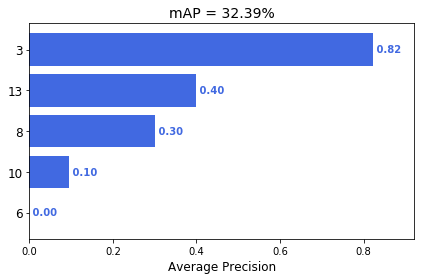

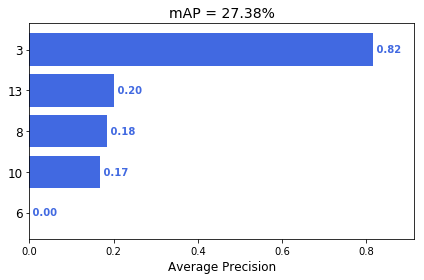

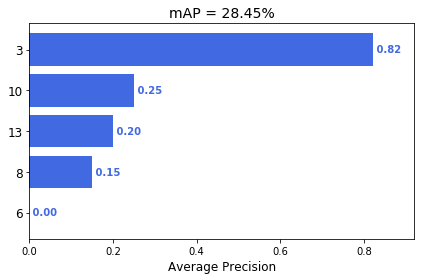

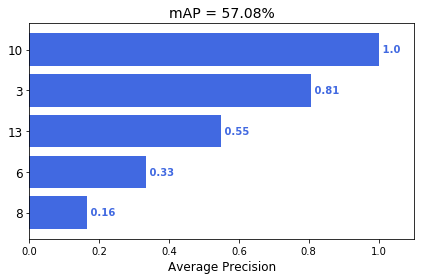

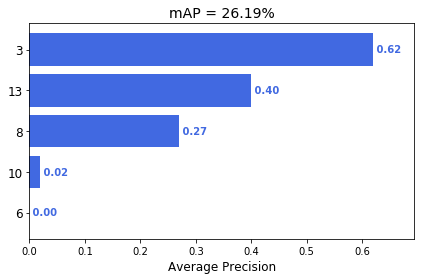

In [21]:
print('Workind Directory: ',os.getcwd())
ALGO =[]
mAP_Score =[]
summary = pd.DataFrame()
for i in range(0, 5):
    Algo, mAP = run(i)
    ALGO = ALGO+[Algo]
    mAP_Score =mAP_Score+[mAP]

summary['Algorthm'] = ALGO
summary['mAP'] = mAP_Score
summary['Condition'] = 'night'
summary.to_csv('mAP_summary.csv')

In [4]:
print('mAP calculations Complete.....')


processing Complete
/home/kevimwe/tensorflow/models/research/object_detection/CapstoneA/samples-1k/Driving_condition/day
